In [1]:
%matplotlib widget
import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import polygon, polygon2mask
import glob
import numpy as np
import cv2
from matplotlib import pyplot as plt

import os
import sys  
sys.path.insert(0, '../dip_utils')

from matrix_utils import arr_info
from vis_utils import (vis_rgb_cube,
                       vis_hists,
                       vis_pair, 
                       vis_triple)

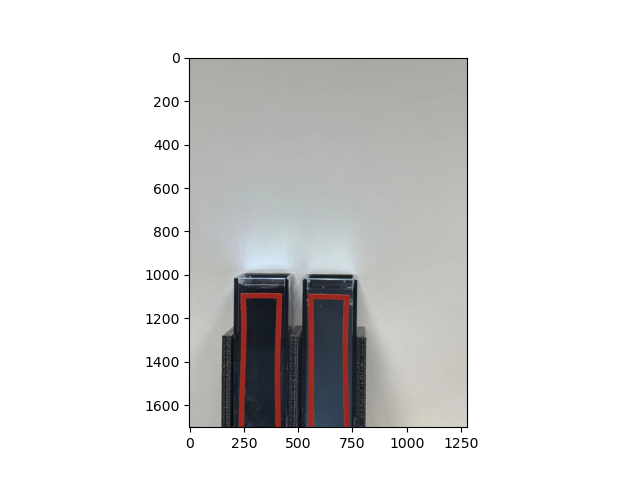

In [2]:
path = '../stacked_new/NTU108.jpg'
img = plt.imread(path)
filename = os.path.basename(path)
plt.figure()
plt.imshow(img)

In [3]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [4]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [5]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [6]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

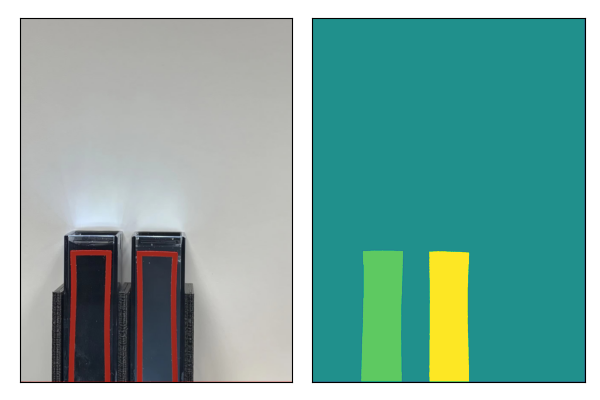

In [7]:
vis_pair(img, markers)

In [8]:
# Acquire the bottom of the ROI
bottom = np.where(markers==2)[0].max()
bottom

1700

In [9]:
# Acquire the leftmost side of the ROI
left = np.where(markers==2)[1].min()
left

228

In [10]:
# Some threshold values
vert_thres = 500
horz_thres = 50
length = 80
dist = 350

In [11]:
# Avoid Extracting incorrect ROI
while markers[bottom-vert_thres, left+horz_thres] == 1:
    left += horz_thres
left

228

In [12]:
coord_left = np.array([[bottom, left+horz_thres], [bottom, left+horz_thres+length], 
                       [bottom-vert_thres, left+horz_thres+length], 
                       [bottom-vert_thres, left+horz_thres]])
coord_right = np.array([[bottom, left+horz_thres+dist], [bottom, left+horz_thres+dist+length], 
                        [bottom-vert_thres, left+horz_thres+dist+length], 
                        [bottom-vert_thres, left+horz_thres+dist]])

In [13]:
I_left = img[coord_left[:,0][0]:coord_left[:,0][2], coord_left[:,1][0]:coord_left[:,1][2]]
I_right = img[coord_right[:,0][0]:coord_right[:,0][2], coord_right[:,1][0]:coord_right[:,1][2]]

In [14]:
rrl, ccl = polygon(coord_left[:,0], coord_left[:,1], shape=img.shape[:2])
rrr, ccr = polygon(coord_right[:,0], coord_right[:,1], shape=img.shape[:2])

In [15]:
mask_l = np.zeros(img.shape[:2])
mask_l[rrl,ccl] = 1
mask_r = np.zeros(img.shape[:2])
mask_r[rrr, ccr] = 1

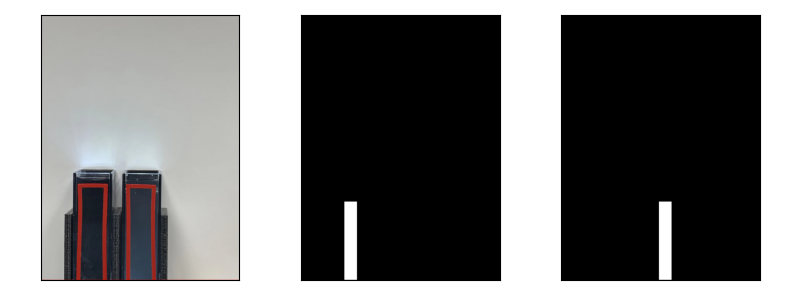

In [16]:
# Visualize Extracted ROI
vis_triple(img, np.clip(img*mask_l[..., None], 0, 1), np.clip(img*mask_r[..., None], 0, 1))

In [17]:
#If it's a multi-channel image, try to get it in [0,255]
def to_single_channel(I):
    if (len(I.shape) > 2):
        Ig = 0.2989 * I[..., 0] + 0.5870 * I[..., 1] + 0.1140 * I[..., 2]
        I = Ig

        I = I/I.ravel().max()
        I = 255*I
        I = np.round(I)
        I[I>255] = 255
        I = I.copy().astype('uint8')
        return I

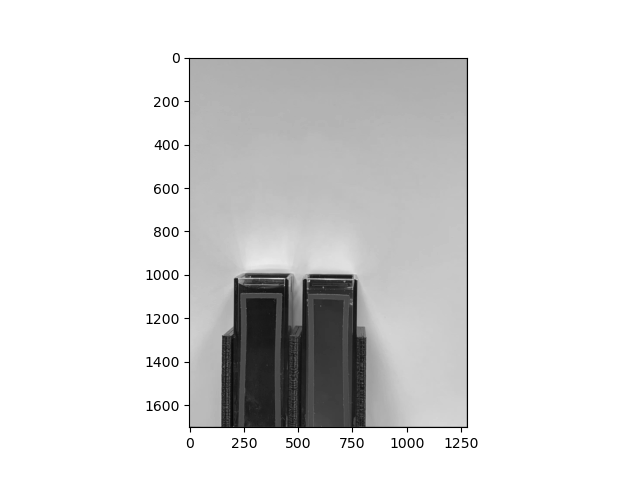

In [18]:
img = to_single_channel(img)
arr_info(img)
plt.figure()
plt.imshow(img, cmap='gray')

In [19]:
x = []
x1 = []
y = []
y1 = []
for i in range(bottom, bottom-vert_thres, -1):
    x.append(i)
    y.append(np.mean(img[i-1:i, left+horz_thres:left+horz_thres+length]))
for i in range(bottom, bottom-vert_thres, -1):
    x1.append(i)
    y1.append(np.mean(img[i-1:i, left+horz_thres+dist:left+horz_thres+dist+length]))

In [20]:
x = np.array(x)
x1 = np.array(x1)
y = np.array(y)
y1 = np.array(y1)

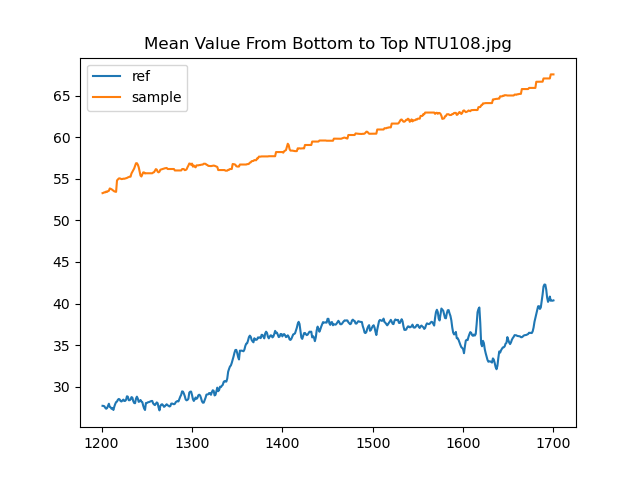

In [21]:
plt.figure()
plt.plot(x,y,label='ref')
plt.plot(x1,y1,label='sample')
plt.title("Mean Value From Bottom to Top %s" % filename)
plt.legend()
plt.show()

In [22]:
path = '../stacked_images/clear.jpg'
J = plt.imread(path)
filename1 = os.path.basename(path)
plt.figure()
plt.imshow(J)

FileNotFoundError: [Errno 2] No such file or directory: '../stacked_images/clear.jpg'

In [ ]:
x = []
x1 = []
y = []
y1 = []
for i in range(1699, 1699-vert_thres, -1):
    x.append(i)
    y.append(np.mean(J[i-1:i, 400:400+length]))
for i in range(bottom, bottom-vert_thres, -1):
    x1.append(i)
    y1.append(np.mean(J[i-1:i, 750:750+length]))

In [ ]:
x = np.array(x)
x1 = np.array(x1)
y = np.array(y)
y1 = np.array(y1)

In [ ]:
plt.figure()
plt.plot(x,y,label='ref')
plt.plot(x1,y1,label='sample')
plt.title("Mean Value From Bottom to Top %s" % filename1)
plt.legend()
plt.show()

In [ ]:
I = plt.imread('../stacked_new/NTU224.jpg')
J = plt.imread('../stacked_new/NTU212.jpg')
vis_pair(I, J)